# 04: Adversarial Exploration

In this chapter I want to explore the possibilities for generating an adversarial example image that cannot be  classified correctly. For example, we might have an image of a car and we want the neural network to misclassify it as a pedestrian or any other type of object based on the outputs of the neural network. 

To generate an adversarial example we will need get the gradient of the image with respect to the wrong classification so that we can slightly change the image. If we repeat that step over and over again we should yield an image that still looks like the original one but yields a wrong classification

#### Installation
For this chapter I will use PyTorch again because I really like PyTorch and use it on a day to day basis. Use the following conda command to install pytorch on your machine:

```shell
conda install pytorch torchvision -c pytorch
```

Furthermore, I will use a pretrained model (e.g. AlexNet) for image classification. You can download the weights for a trained AlexNet under the following link and store it in the `data` folder within the subfolder `04_Adversarial`. You could also use the pretrained flag but that will give you now control over the weights that the model is actually using.

https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth

In [71]:
import torch

import matplotlib.pyplot as plt

from PIL import Image

import torch.nn.functional as F

from torchvision.models import AlexNet
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, ToPILImage

#### Pretrained AlexNet

We first need to load the pretrained weights so that we can initialize the model with the weights. Otherwise you would need to retrain the model so that it achieves good classification outputs. After that I wanted to see if the model really works so I decided the forward pass an image through the network. But before I was able to do that I had to figure out how the output looks like and what class predictions it can generate (e.g. car, train, bus).

The model seems to be trained on the ImageNet data because there are 1000 output features. To get the actual "probability" for each of the 1000 classes we probably still need to pass the logits through a softmax activation. Logits describe the values of the neurons of the last layer before the final activation (e.g. softmax) occurs. Furthermore, you can take a look at the documentation which will also tell you that there are 1000 output classes from the ImageNet training data (https://pytorch.org/docs/stable/_modules/torchvision/models/alexnet.html#alexnet)

In [72]:
model = AlexNet()
pretrained_weights = torch.load('./data/alexnet-owt-4df8aa71.pth')
model.load_state_dict(pretrained_weights)
model.eval()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### CIFAR-10 Dataset

Fortunately, PyTorch also provides developers with datasets like ImageNet or CIFAR-10. To test our AlexNet I would like to use the CIFAR-10 dataset which is a vision dataset that consists of 10 different class labels and has about 60000 different images. Each image has a size of 32 x 32 pixels which is quite small. You can download the dataset from PyTorch with the following piece of code. Keep in mid to add the import from the beginning of thsi notebook. You can find the 10 different class labels on the official CIFAR-10 website (https://www.cs.toronto.edu/~kriz/cifar.html):

Files already downloaded and verified


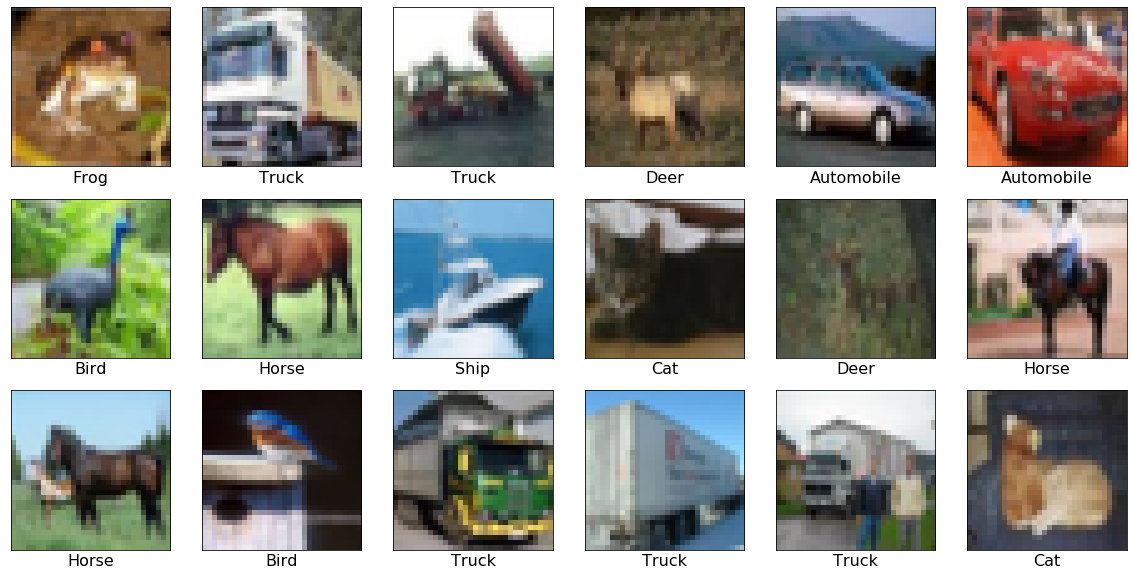

In [73]:
cifar10_data = CIFAR10(root="./data/" ,download=True)

label_names = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(20,10))
for i in range(18):
    image, label = cifar10_data[i]
    plt.subplot(3,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel(label_names[label], fontsize=16)
plt.show()

#### Fast Gradient Sign Attack
For this tutorial I will use the fast gradient sign attack which is a very simple attack to change an existing image and its correct output to a wrong output. For this kind of attack we cannot say what our desired output class is.

tensor([[80]])


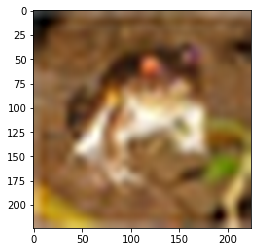

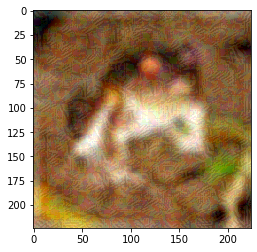

tensor([[901]])


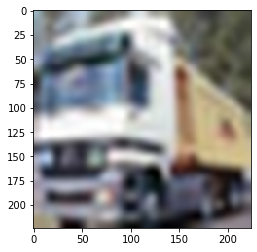

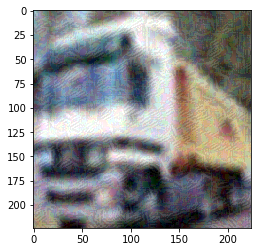

tensor([[111]])


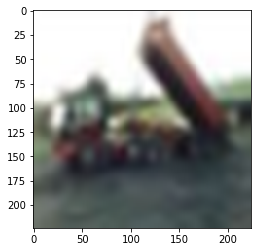

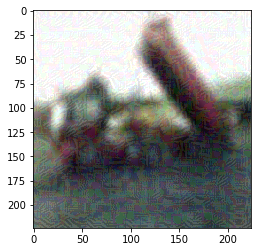

tensor([[901]])


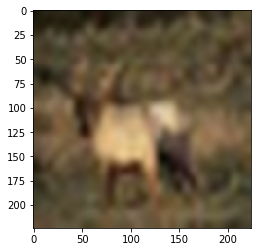

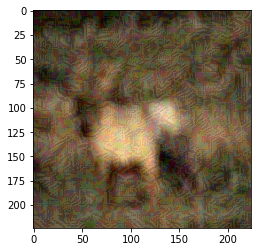

tensor([[623]])


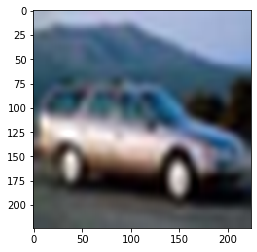

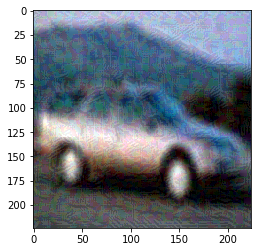

tensor([[73]])


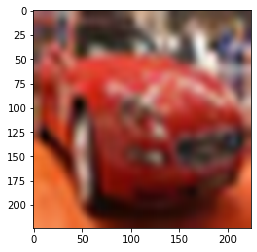

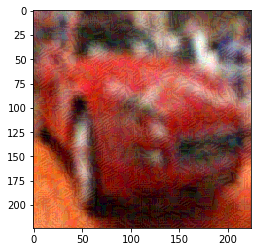

tensor([[135]])


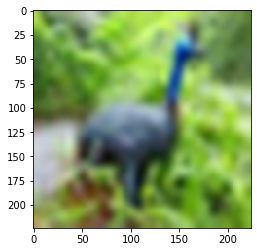

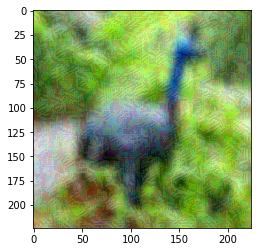

tensor([[351]])


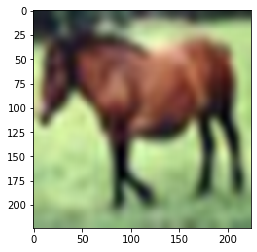

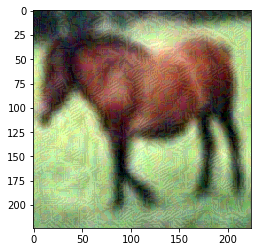

tensor([[813]])


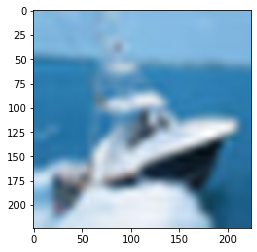

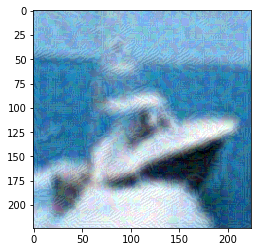

tensor([[901]])


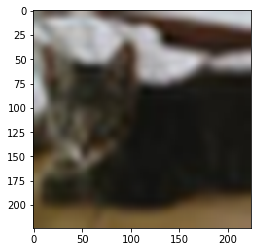

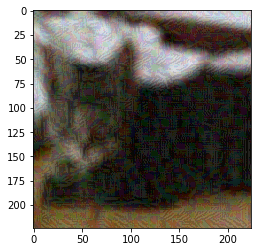

In [106]:
for i in range(10):
    # Load one image and the corresponding label from the dataset
    original_image, original_label = cifar10_data.__getitem__(i)

    # Preprocess the image and the label so that it will fit in the network
    original_pil_image = original_image.resize((224,224),Image.ANTIALIAS)

    # Convert the inputs and targets to torch Tensors
    transform_to_tensor = ToTensor()
    transform_to_PIL = ToPILImage()
    original_label = torch.tensor([original_label])
    original_image = transform_to_tensor(original_pil_image)
    original_image = original_image.unsqueeze(dim=0)
    original_image.requires_grad = True

    # Forward pass the image and collect the gradients
    original_output = model(original_image)
    print(original_output.max(1, keepdim=True)[1])
    loss = F.nll_loss(original_output, original_label)
    model.zero_grad()
    loss.backward()

    # Build the adversarial image based on the collected gradients
    adversarial_image = original_image + 0.05 * original_image.grad.data.sign()
    adversarial_image = torch.clamp(adversarial_image, 0, 1)
    adversarial_image = transform_to_PIL(adversarial_image[0])

    plt.imshow(original_pil_image)
    plt.show()

    plt.imshow(adversarial_image)
    plt.show()

## Takeaways

1. It seems to be quite easy to generate an adversarial example. You do not need a lot of computing power especially if you only want to generate a single adversarial example. However, I would like to explore some other techniques that are more sophisticated like generating a path that makes object disappear. For that I would like to use YOLO which is one of the SOTA object detection models. You can find more about YOLO and its performance here:
  
  https://pjreddie.com/darknet/yolo/
    
    

2. The pretrained PyTorch models and Datasets are very handy and easy to use. Especially if you want to do something like object detection it might make sense to use a pretrained vision model. This type of learning is called transfer learning because our pretrained model already knows how objects might look like and the first few layers for feature extraction are already trained. This would allow our more advanced model to use that kind of representation to solve its own task. Finally, this might save you a lot of training time and compute. Thus, keep the following imports in mind:

```python
from torchvision.models import AlexNet
from torchvision.datasets import CIFAR10
```
